In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']="TRUE"
import torch
import torch.nn as nn
import torch.optim as optim

#使用torchtext构建语料库，
from torchtext.legacy import data,datasets
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic=True
#使用spacy这个标记器将连续的字符串标记，不设置默认情况是将字符串拆分为空格，后面的language表示的是我们的使用的拆分模型
#使用RNN进行处理的时候，需要知道我们的序列有多少，设置include_lengths=True
TEXT=data.Field(tokenize='spacy',tokenizer_language='en_core_web_sm',include_lengths=True)
LABEL=data.LabelField(dtype=torch.float)
#使用GPU加速 检查cuda是否可用
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    print("using cuda:",torch.cuda.get_device_name(0))
device=torch.device("cuda")
print(device)

using cuda: Tesla P100-PCIE-16GB
cuda


In [2]:
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:08<00:00, 10.2MB/s]


In [3]:
import random
train_data, valid_data = train_data.split(random_state = random.seed(SEED))

In [4]:
MAX_VOCAB_SIZE = 25_000
TEXT.build_vocab(train_data,
                 max_size = MAX_VOCAB_SIZE,
                 vectors = "glove.6B.100d",
                 unk_init = torch.Tensor.normal_)
LABEL.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [02:43, 5.28MB/s]                               
100%|█████████▉| 399999/400000 [00:30<00:00, 12920.40it/s]


In [37]:
BATCH_SIZE =16
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device=device
    )

In [38]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
#使用regularization防止model过拟合
DROPOUT = 0.5
#从词汇表中获取我们的填充标志索引，从字段的pad_token属性中获取填充标记的真实的实际的字符串
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

In [39]:
'''
:parameter vocab_size,embedding_dim,hidden_dim,out_dim,n_layers,bidirectional,dropout,pad_idx
           text text_lengths
:notice 另外，请注意，LSTM 返回输出以及最终隐藏状态和最终单元状态的元组，而标准 RNN 仅返回输出和最终隐藏状态。
        永远不要在输入或输出层（在这种情况下为 text 或 fc）使用 dropout，您只想在中间层上使用 dropout。
        LSTM 有一个 dropout 参数，它在一层中的隐藏状态与下一层中的隐藏状态之间的连接上添加 dropout。
        由于我们想要最终（顶层）的前向和后向隐藏状态，我们从第一维得到前两个隐藏层，hidden[-2,:,:] 和 hidden[-1,:,:]，
        并将它们连接起来在将它们传递到线性层之前（在应用 dropout 之后）。

        最终的隐藏状态 hidden 的形状为 [num layers * num direction, batch size, hid dim]。
        这些是有序的：[forward_layer_0，backward_layer_0，forward_layer_1，backward_layer 1，...，forward_layer_n，backward_layer n]。
        由于我们想要最终（顶层）的前向和后向隐藏状态，我们从第一维得到前两个隐藏层，hidden[-2,:,:] 和 hidden[-1,:,:]，
        并将它们连接起来在将它们传递到线性层之前（在应用 dropout 之后）。
'''
class RNN(nn.Module):
    def __init__(self,vocab_size,embedding_dim,hidden_dim,out_dim,n_layers,bidirectional,dropout,pad_idx):
        super().__init__()
        #我们的模型填充标记与确定句子的情绪无关,使用pad_idx
        self.embedding=nn.Embedding(vocab_size,embedding_dim,pad_idx)
        #通过添加bid和n_layers实现双向和添加额外的层
        self.rnn=nn.LSTM(embedding_dim,hidden_dim,num_layers=n_layers,bidirectional=bidirectional,dropout=dropout)
        #我们的lstm有foward和backward两个部分，因此我们的是hidden_dim*2
        self.fc=nn.Linear(hidden_dim*2,out_dim)
        #dropout参数表示丢弃神经元的概率
        self.dropout=nn.Dropout(dropout)
    def forward(self,text,text_lengths):
        embedded=self.dropout(self.embedding(text))
        packed_embedded=nn.utils.rnn.pack_padded_sequence(embedded,text_lengths.to('cpu'))
        packed_out,(hidden,cell)=self.rnn(packed_embedded)
        hidden=self.dropout(torch.cat((hidden[-2,:,:],hidden[-1,:,:]),dim=1))
        return self.fc(hidden)

In [40]:
model=RNN(vocab_size=INPUT_DIM,embedding_dim=EMBEDDING_DIM,hidden_dim=HIDDEN_DIM,out_dim=OUTPUT_DIM,n_layers=N_LAYERS,bidirectional=BIDIRECTIONAL,dropout=DROPOUT,pad_idx=PAD_IDX)
#模型参数的统计
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,810,857 trainable parameters


In [41]:
pretrained_embeddings=TEXT.vocab.vectors
print(pretrained_embeddings.shape)

torch.Size([25002, 100])


In [42]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-1.6165,  0.5685, -0.5102,  ...,  2.2414, -0.0409, -0.4989],
        [ 0.6331,  1.6358, -0.3459,  ...,  0.2740, -1.7484,  1.2518],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.0175, -0.0485,  0.4117,  ..., -0.5030,  1.3068, -0.5548],
        [-0.3859,  0.7198,  0.7405,  ...,  0.2773, -0.0964, -0.1760],
        [-0.1797, -0.3282,  0.4366,  ..., -0.3601,  0.0957,  0.1510]])

In [43]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.0175, -0.0485,  0.4117,  ..., -0.5030,  1.3068, -0.5548],
        [-0.3859,  0.7198,  0.7405,  ...,  0.2773, -0.0964, -0.1760],
        [-0.1797, -0.3282,  0.4366,  ..., -0.3601,  0.0957,  0.1510]])


In [44]:
optimizer=optim.Adam(model.parameters())
lossfunction=nn.BCEWithLogitsLoss()
model=model.to(device)
lossfunction=lossfunction.to(device)

In [45]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

In [46]:
import tqdm
import sys
def train(model,iterator,optimizer,lossfunction):
    epoch_loss=[]
    epoch_acc=[]
    model.train()
    count=0
    for batch in tqdm.tqdm(iterator,desc='training....',file=sys.stdout):
        text,textlength=batch.text
        optimizer.zero_grad()
        prediction=model(text,textlength.to('cpu')).squeeze(1)
        loss=lossfunction(prediction,batch.label)
        acc=binary_accuracy(prediction,batch.label)
        loss.backward()
        optimizer.step()
        if(count%10==0):
            epoch_loss.append(loss.item())
            epoch_acc.append(acc.item())

    return epoch_loss , epoch_acc

In [47]:
def eval(model,iterator,lossfunction):
    epoch_loss=[]
    epoch_acc=[]
    model.eval()
    with torch.no_grad():
        count=0
        for batch in tqdm.tqdm(iterator,desc='evaluating....',file=sys.stdout):
            text,textlength=batch.text
            optimizer.zero_grad()
            prediction=model(text,textlength.to('cpu')).squeeze(1)
            loss=lossfunction(prediction,batch.label)
            acc=binary_accuracy(prediction,batch.label)
            count=count+1
            if(count%10==0):
                epoch_loss.append(loss.item())
                epoch_acc.append(acc.item())
    return epoch_loss , epoch_acc

In [48]:
import time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [49]:
import numpy as np
n_epochs = 10
best_valid_loss = float('inf')

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(n_epochs):

    train_loss, train_acc = train(iterator=train_iterator, model=model, lossfunction=lossfunction, optimizer=optimizer)
    valid_loss, valid_acc = eval(iterator=valid_iterator, model=model, lossfunction=lossfunction)

    train_losses=train_losses+train_loss
    train_accs=train_accs+train_acc
    valid_losses=valid_losses+valid_loss
    valid_accs=valid_accs+valid_acc

    epoch_train_loss = np.mean(train_loss)
    epoch_train_acc = np.mean(train_acc)
    epoch_valid_loss = np.mean(valid_loss)
    epoch_valid_acc = np.mean(valid_acc)

    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        torch.save(model.state_dict(), r'D:\Python\Python_Project\Python LSTM\Sentiment Analysis （LSTM　CNN　RNN）\bi_lstm.pt')

    print(f'epoch: {epoch+1}')
    print(f'train_loss: {epoch_train_loss:.3f}, train_acc: {epoch_train_acc:.3f}')
    print(f'valid_loss: {epoch_valid_loss:.3f}, valid_acc: {epoch_valid_acc:.3f}')

evaluating....: 100%|██████████| 469/469 [00:10<00:00, 44.88it/s] 
epoch: 1
train_loss: 0.693, train_acc: 0.529
valid_loss: 0.675, valid_acc: 0.605
evaluating....: 100%|██████████| 469/469 [00:10<00:00, 45.13it/s] 
epoch: 2
train_loss: 0.554, train_acc: 0.717
valid_loss: 0.363, valid_acc: 0.848
evaluating....: 100%|██████████| 469/469 [00:10<00:00, 44.80it/s] 
epoch: 3
train_loss: 0.328, train_acc: 0.865
valid_loss: 0.314, valid_acc: 0.874
evaluating....: 100%|██████████| 469/469 [00:10<00:00, 44.54it/s] 
epoch: 4
train_loss: 0.244, train_acc: 0.906
valid_loss: 0.350, valid_acc: 0.870
evaluating....: 100%|██████████| 469/469 [00:10<00:00, 44.78it/s] 
epoch: 5
train_loss: 0.196, train_acc: 0.926
valid_loss: 0.315, valid_acc: 0.876
evaluating....: 100%|██████████| 469/469 [00:10<00:00, 45.16it/s] 
epoch: 6
train_loss: 0.160, train_acc: 0.942
valid_loss: 0.278, valid_acc: 0.891
evaluating....: 100%|██████████| 469/469 [00:10<00:00, 45.41it/s] 
epoch: 7
train_loss: 0.132, train_acc: 0.951


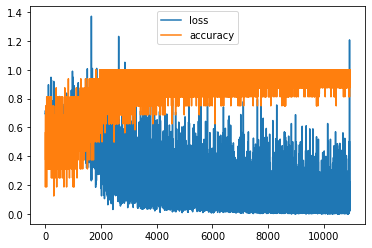

In [50]:
import matplotlib.pyplot as plt
import pandas as pd
plt.rc('font',family='Times New Roman',size=10)
df = pd.DataFrame(train_losses, columns=['loss'])
df2=pd.DataFrame(train_accs,columns=['accuracy'])
plt.plot(range(len(train_losses)),df['loss'])
plt.plot(range(len(train_accs)),df2['accuracy'])
plt.legend(['loss','accuracy'])

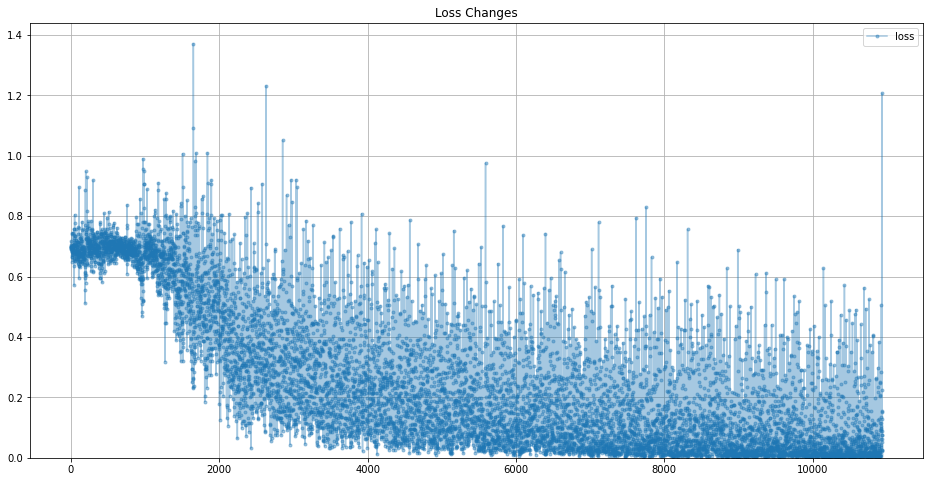

In [51]:
def plot_progress(progress):
        df = pd.DataFrame(progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.4, marker='.', grid=True)
        plt.title('Loss Changes')
plot_progress(train_losses)


In [52]:
model.load_state_dict(torch.load(r'./D:\Python\Python_Project\Python LSTM\Sentiment Analysis （LSTM　CNN　RNN）\bi_lstm.pt'))

test_loss, test_acc = eval(iterator=test_iterator, model=model, lossfunction=lossfunction)
epoch_test_loss = np.mean(test_loss)
epoch_test_acc = np.mean(test_acc)
print(f'test_loss: {epoch_test_loss:.3f}, test_acc: {epoch_test_acc:.3f}')

evaluating....: 100%|██████████| 1563/1563 [00:33<00:00, 46.24it/s]
test_loss: 0.268, test_acc: 0.893
